# Assay Annotations
This notebook explores the annotation data for a given set of assays from PubChem. 

Run `pubchem_assay_annotations.py` BEFORE using this notebook to get the required input file (assay ids with annotation info).

In [1]:
# run pubchem_assay_annotations.py to generate this file
ANNOTATIONS_JSON_FILE = "/media/jack/big_disk/data/badapple/assay_annotations_tested.json"

## Setup

In [2]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [3]:
# load data
with open(ANNOTATIONS_JSON_FILE, "r") as f:
    ann_data = json.load(f)

## Visualizing annotations from BARD

TODO: may want to try to incorporate other data sources, but if using multiple sources need a way to standardize terms 

In [4]:
n_assays = len(ann_data["Annotations"])
print("Total number of assays:", n_assays)

Total number of assays: 823


In [5]:
def get_source_ref_num(aid_ref_list: list[dict], source: str) -> int:
    for ref in aid_ref_list:
        if "SourceName" in ref and ref["SourceName"] == source:
            return ref["ReferenceNumber"]
    return -1

In [6]:
BARD_sourcename = "BioAssay Research Database (BARD)"
aid_2_bardrefnum = {}
for aid in ann_data["References"]:
    aid_2_bardrefnum[aid] = get_source_ref_num(ann_data["References"][aid], BARD_sourcename)

In [7]:
BARD_ANNOTATION_TYPES = ['Assay Format', 'Assay Type', 'Detection Method']

In [8]:
# for each annotation type (Assay Format, Assay Type, Detection Method)
# store a list of all the terms
bard_annotations = {ann_name: [] for ann_name in BARD_ANNOTATION_TYPES}
for aid, ref_n in aid_2_bardrefnum.items():
    if ref_n == -1:
        # AID not in BARD
        # add "UNKNOWN" for entries not in BARD
        for ann_name in BARD_ANNOTATION_TYPES:
            bard_annotations[ann_name].append("UNKNOWN")
    else:
        # AID has entry in BARD
        aid_annotations = ann_data["Annotations"][aid]
        remaining_terms = BARD_ANNOTATION_TYPES.copy()
        for annotation in aid_annotations:
            if annotation["ReferenceNumber"] == ref_n:
                ann_name = annotation["Name"]
                ann_val = annotation["Value"]
                if ann_name in bard_annotations:
                    bard_annotations[ann_name].append(ann_val)
                else:
                    bard_annotations[ann_name] = [ann_val]
                remaining_terms.remove(ann_name)
        # add "NULL" for partially-labeled entries
        for ann_name in remaining_terms:
            bard_annotations[ann_name].append("NULL")

In [9]:
assert list(bard_annotations.keys()) == BARD_ANNOTATION_TYPES
bard_annotations.keys()

dict_keys(['Assay Format', 'Assay Type', 'Detection Method'])

In [10]:
def get_frequency_df(d: dict[str, list[str]], key: str) -> pd.DataFrame:
    term_counts = Counter(d[key])
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df

In [11]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int) -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df['Frequency'] > thresh]
    other_freq_sum = df[df['Frequency'] <= thresh]['Frequency'].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df_high_freq

In [12]:
def plot_term_counts(frequency_df: pd.DataFrame, key: str):
    n_total = sum(frequency_df['Frequency'])
    assert n_total == n_assays, n_total

    plt.figure(figsize=(10, 6))
    plt.bar(frequency_df['Term'], frequency_df['Frequency'], color='skyblue')

    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title(f'Frequency of {key} Terms, N={n_total}')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [13]:
# get dataframes 
annotation_2_df = {}
for ann_name in bard_annotations.keys():
    annotation_2_df[ann_name] = get_frequency_df(bard_annotations, ann_name)

### Assay Format

In [14]:
annotation_2_df['Assay Format']

,Term,Frequency
0,cell-based format,319
1,UNKNOWN,155
2,single protein format,89
3,biochemical format,87
4,protein format,84
5,protein complex format,44
6,organism-based format,17
7,small-molecule format,14
8,nucleic acid format,5
9,whole-cell lysate format,3


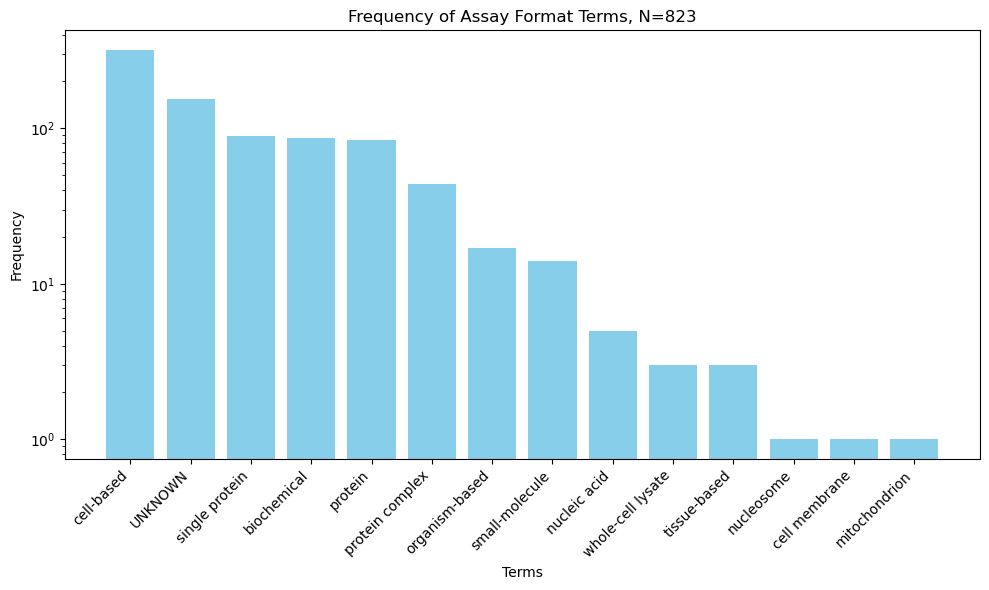

In [15]:
# remove redundant substr "format" for plot
annotation_2_df['Assay Format']["Term"] = annotation_2_df['Assay Format']["Term"].map(lambda x: x.replace(' format', ''))
plot_term_counts(annotation_2_df['Assay Format'], 'Assay Format')

### Assay Type

In [16]:
annotation_2_df['Assay Type']

,Term,Frequency
0,UNKNOWN,155
1,protein-small molecule interaction assay,120
2,direct enzyme activity assay,103
3,protein-protein interaction assay,80
4,reporter-gene assay,71
5,coupled enzyme activity assay,36
6,cytotoxicity assay,34
7,enzyme activity assay,33
8,protein expression assay,17
9,ion-channel assay,16


In [17]:
# for the sake of plotting, group together terms which occur <= 5 times
annotation_2_df['Assay Type'] = get_high_frequency_df(annotation_2_df['Assay Type'], 5)

/tmp/ipykernel_117151/1579741084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


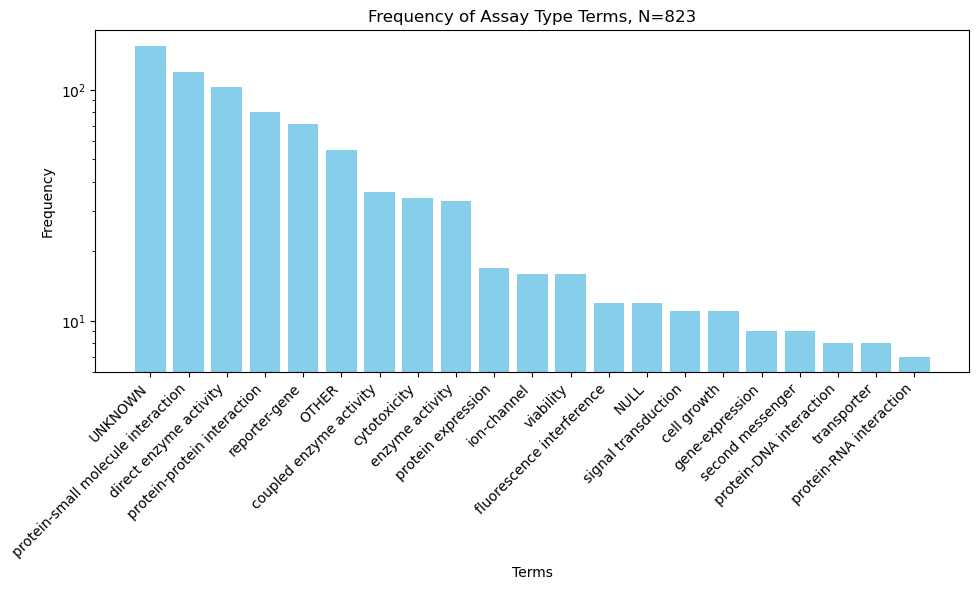

In [18]:
# remove redundant substr "assay" for plot
annotation_2_df['Assay Type']["Term"] = annotation_2_df['Assay Type']["Term"].map(lambda x: x.replace(' assay', ''))
plot_term_counts(annotation_2_df['Assay Type'], 'Assay Type')

### Detection Method

In [19]:
annotation_2_df['Detection Method']

,Term,Frequency
0,fluorescence intensity,219
1,UNKNOWN,155
2,bioluminescence,84
3,fluorescence polarization,63
4,luminescence method,63
5,fluorescence method,50
6,chemiluminescence,46
7,fluorescence resonance energy transfer,38
8,absorbance,35
9,flow cytometry,14


In [20]:
# for the sake of plotting, group together terms which occur <= 5 times
annotation_2_df['Detection Method'] = get_high_frequency_df(annotation_2_df['Detection Method'], 5)

/tmp/ipykernel_117151/1579741084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


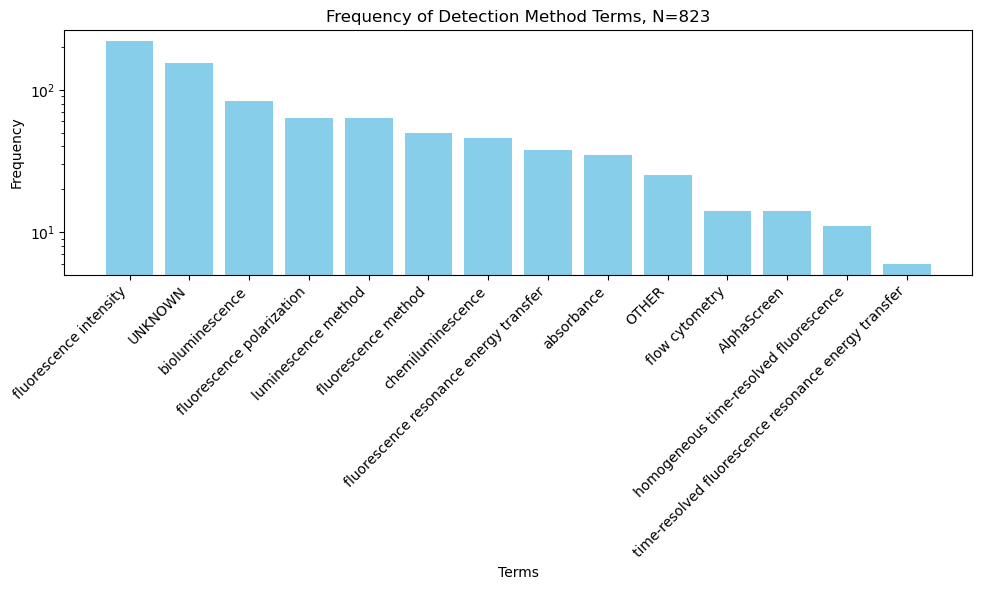

In [21]:
plot_term_counts(annotation_2_df['Detection Method'], 'Detection Method')